In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import and process the data
Import the clusters obtained with the feature-maps using different feature combinations.
Process the data to extract the list of clusters and the list of merged adjacent clusters.

In [6]:
import os

import numpy as np
import pandas as pd
from scipy.ndimage import label

from config import FEATURE_MAP_CLUSTERS

# Create the base dataframe with the features and the cells containing the clusters
clusters_df = pd.DataFrame(
    [
        {
            'features': file_name.rstrip('_clusters.npy'),
            'cells_clusters': np.load(os.path.join(FEATURE_MAP_CLUSTERS, file_name), allow_pickle=True)
        }
        for file_name in os.listdir(FEATURE_MAP_CLUSTERS)
        if file_name.endswith('_clusters.npy')
    ]
)
clusters_df = clusters_df.set_index('features')
# Get the list of clusters
def get_clusters_list(matrix):
    clusters_flat = matrix.flatten()
    return clusters_flat[clusters_flat != None]
# Get the number of clusters
clusters_df['clusters_list'] = clusters_df['cells_clusters'].apply(get_clusters_list)
clusters_df['num_clusters'] = clusters_df['clusters_list'].apply(len)
# Get the size of the cluster in each cell
clusters_df['cells_size'] = clusters_df['cells_clusters'].apply(np.vectorize(lambda cell: len(cell) if cell is not None else 0))
# Get the matrix for the connected components
shape = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
clusters_df['connected_components'] = clusters_df['cells_size'].apply(lambda matrix: label(matrix, shape)[0])
clusters_df['num_connected_components'] = clusters_df['connected_components'].apply(lambda matrix: len(np.unique(matrix)))
def merge_clusters(clusters_matrix, connected_components):
    merged_clusters = []
    for clusters_label in np.unique(connected_components):
        label_clusters = clusters_matrix[np.where(connected_components == clusters_label)]
        label_clusters = label_clusters[label_clusters != None]
        if len(label_clusters) > 0:
            merged_clusters.append(np.concatenate(label_clusters))

    return merged_clusters
clusters_df['merged_clusters_list'] = clusters_df.apply(lambda row: merge_clusters(row['cells_clusters'], row['connected_components']), axis=1)
clusters_df['num_merged_clusters'] = clusters_df['merged_clusters_list'].apply(len)

clusters_df.to_csv('../logs/feature_combinations_clusters.csv', index=True)
clusters_df

,cells_clusters,clusters_list,num_clusters,cells_size,connected_components,num_connected_components,merged_clusters_list,num_merged_clusters
features,,,,,,,,
moves+orientatio,"[[[339], [28, 277, 453], [119, 125, 210, 263, ...","[[339], [28, 277, 453], [119, 125, 210, 263, 3...",92,"[[1, 3, 5, 5, 20, 22, 34, 33, 40, 42, 48, 46, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",35,"[[339, 28, 277, 453, 119, 125, 210, 263, 370, ...",34
moves+bitma,"[[None, [670], None, [48, 274, 279, 520], [252...","[[670], [48, 274, 279, 520], [252, 254, 426, 5...",88,"[[0, 1, 0, 4, 8, 11, 34, 48, 80, 79, 91, 83, 7...","[[0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",34,"[[670], [48, 274, 279, 520, 252, 254, 426, 507...",33
orientation+bitma,"[[None, None, None, None, None, None, [339], N...","[[339], [453], [28], [277], [125], [263], [119...",241,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",15,"[[339, 453, 28, 125, 263], [277, 119, 370, 210...",14


features,moves+orientatio,moves+bitma,orientation+bitma
features,,,
moves+orientatio,0.000000,0.064452,0.202393
moves+bitma,0.064452,0.000000,0.203176
orientation+bitma,0.202393,0.203176,0.000000


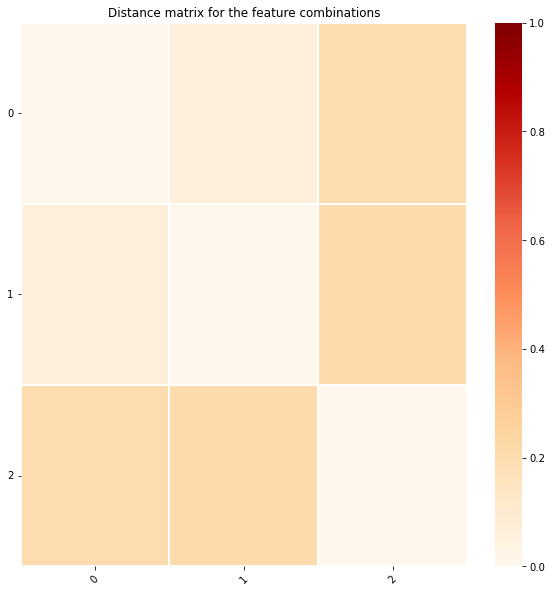

In [3]:
from utils.cluster.preprocessing import distance_matrix
from utils.general import save_figure
from clusim.clustering import Clustering
from clusim.sim import element_sim

feature_maps_clusters = [
    Clustering().from_cluster_list(clusters_configuration)
    for clusters_configuration in clusters_df['merged_clusters_list'].values
]
distance_matrix, fig, ax = distance_matrix(feature_maps_clusters, lambda l, r: 1 - element_sim(l, r), show_map=True)
ax.set_title('Distance matrix for the feature combinations')
save_figure(fig, f'../out/feature_maps/fea')

feature_maps_distances = pd.DataFrame(
    distance_matrix,
    columns=clusters_df['features'],
    index=clusters_df['features']
)
feature_maps_distances

Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)

Found 892/10000 instances for the label 5
Found 167/892 instances for misclassified 5
        


/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


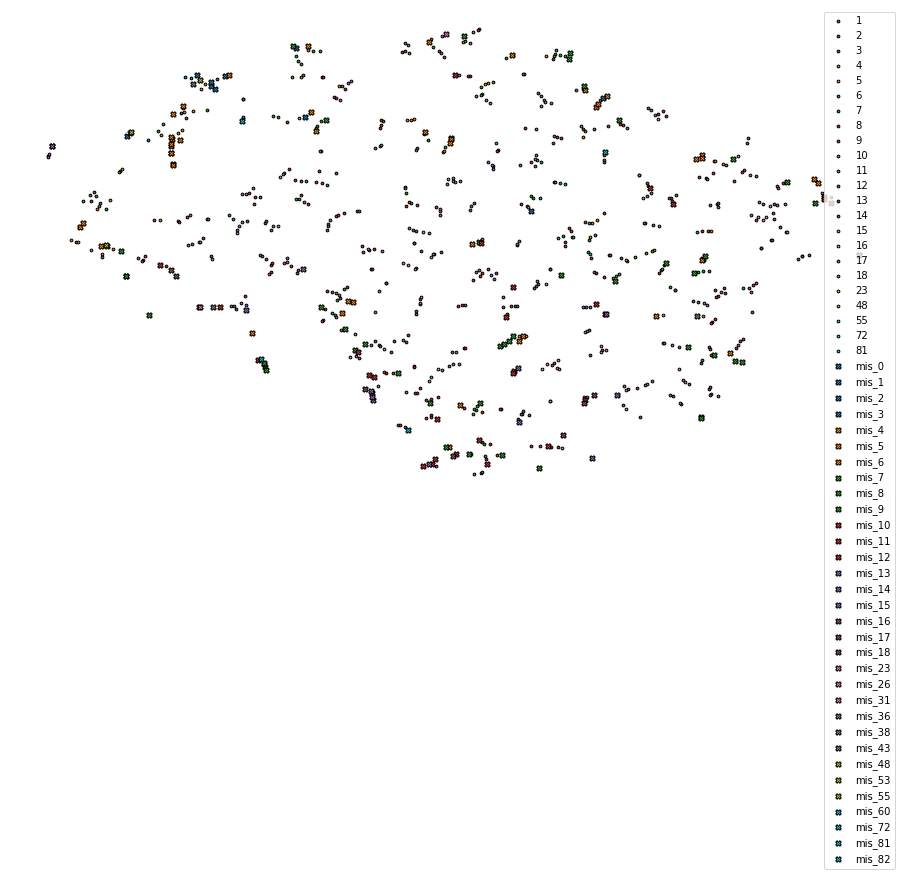

In [62]:

from utils.cluster.visualize import visualize_clusters_projections
import numpy as np
import tensorflow as tf

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

# load the model
classifier = tf.keras.models.load_model(f'../in/models/digit_classifier.h5')
# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=True)

# create the mask for the misclassified items of the selected label
mask_miss_label = mask_miss[mask_label]
# create the mask for the clusters containing misclassified elements of the selected label
clusters = np.array(list(feature_maps_clusters.values())[2].to_membership_list())
mask_contains_miss_label = np.isin(clusters, np.unique(clusters[mask_miss_label]))

# visualize the projections of the contributions for the correct predictions
projections = TSNE(perplexity=3).fit_transform(test_data_gs[mask_label].reshape(test_data_gs[mask_label].shape[0], -1))
fig, ax = visualize_clusters_projections(
    projections=projections[~mask_miss_label & mask_contains_miss_label],
    clusters=clusters[~mask_miss_label & mask_contains_miss_label],
    cmap='tab10', marker='.'
)
# visualize the projections of the contributions for the wrong predictions
visualize_clusters_projections(
    projections=projections[mask_miss_label],
    clusters=clusters[mask_miss_label],
    fig=fig, ax=ax, cmap='tab10', marker='X', label_prefix='mis'
)

# ax.set_title('Projections for the clusters containing both correct and incorrect classifications')
save_figure(fig, f'../out/feature_maps/clusters_projections')

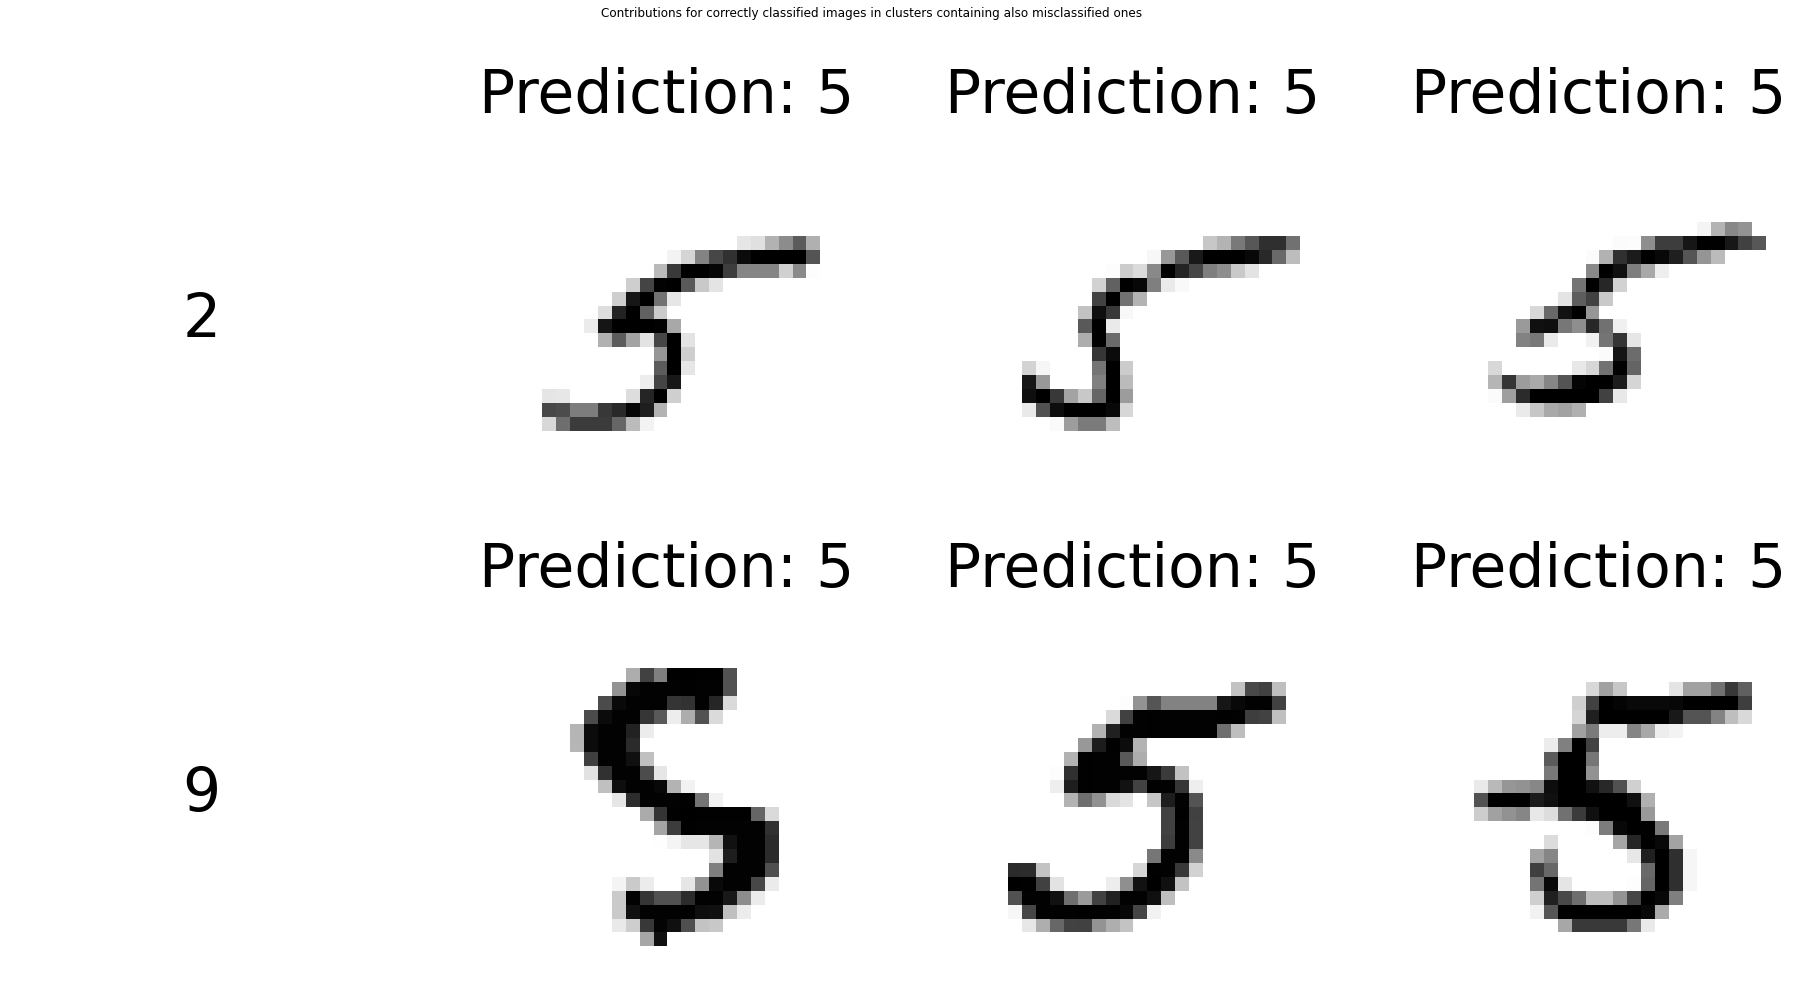

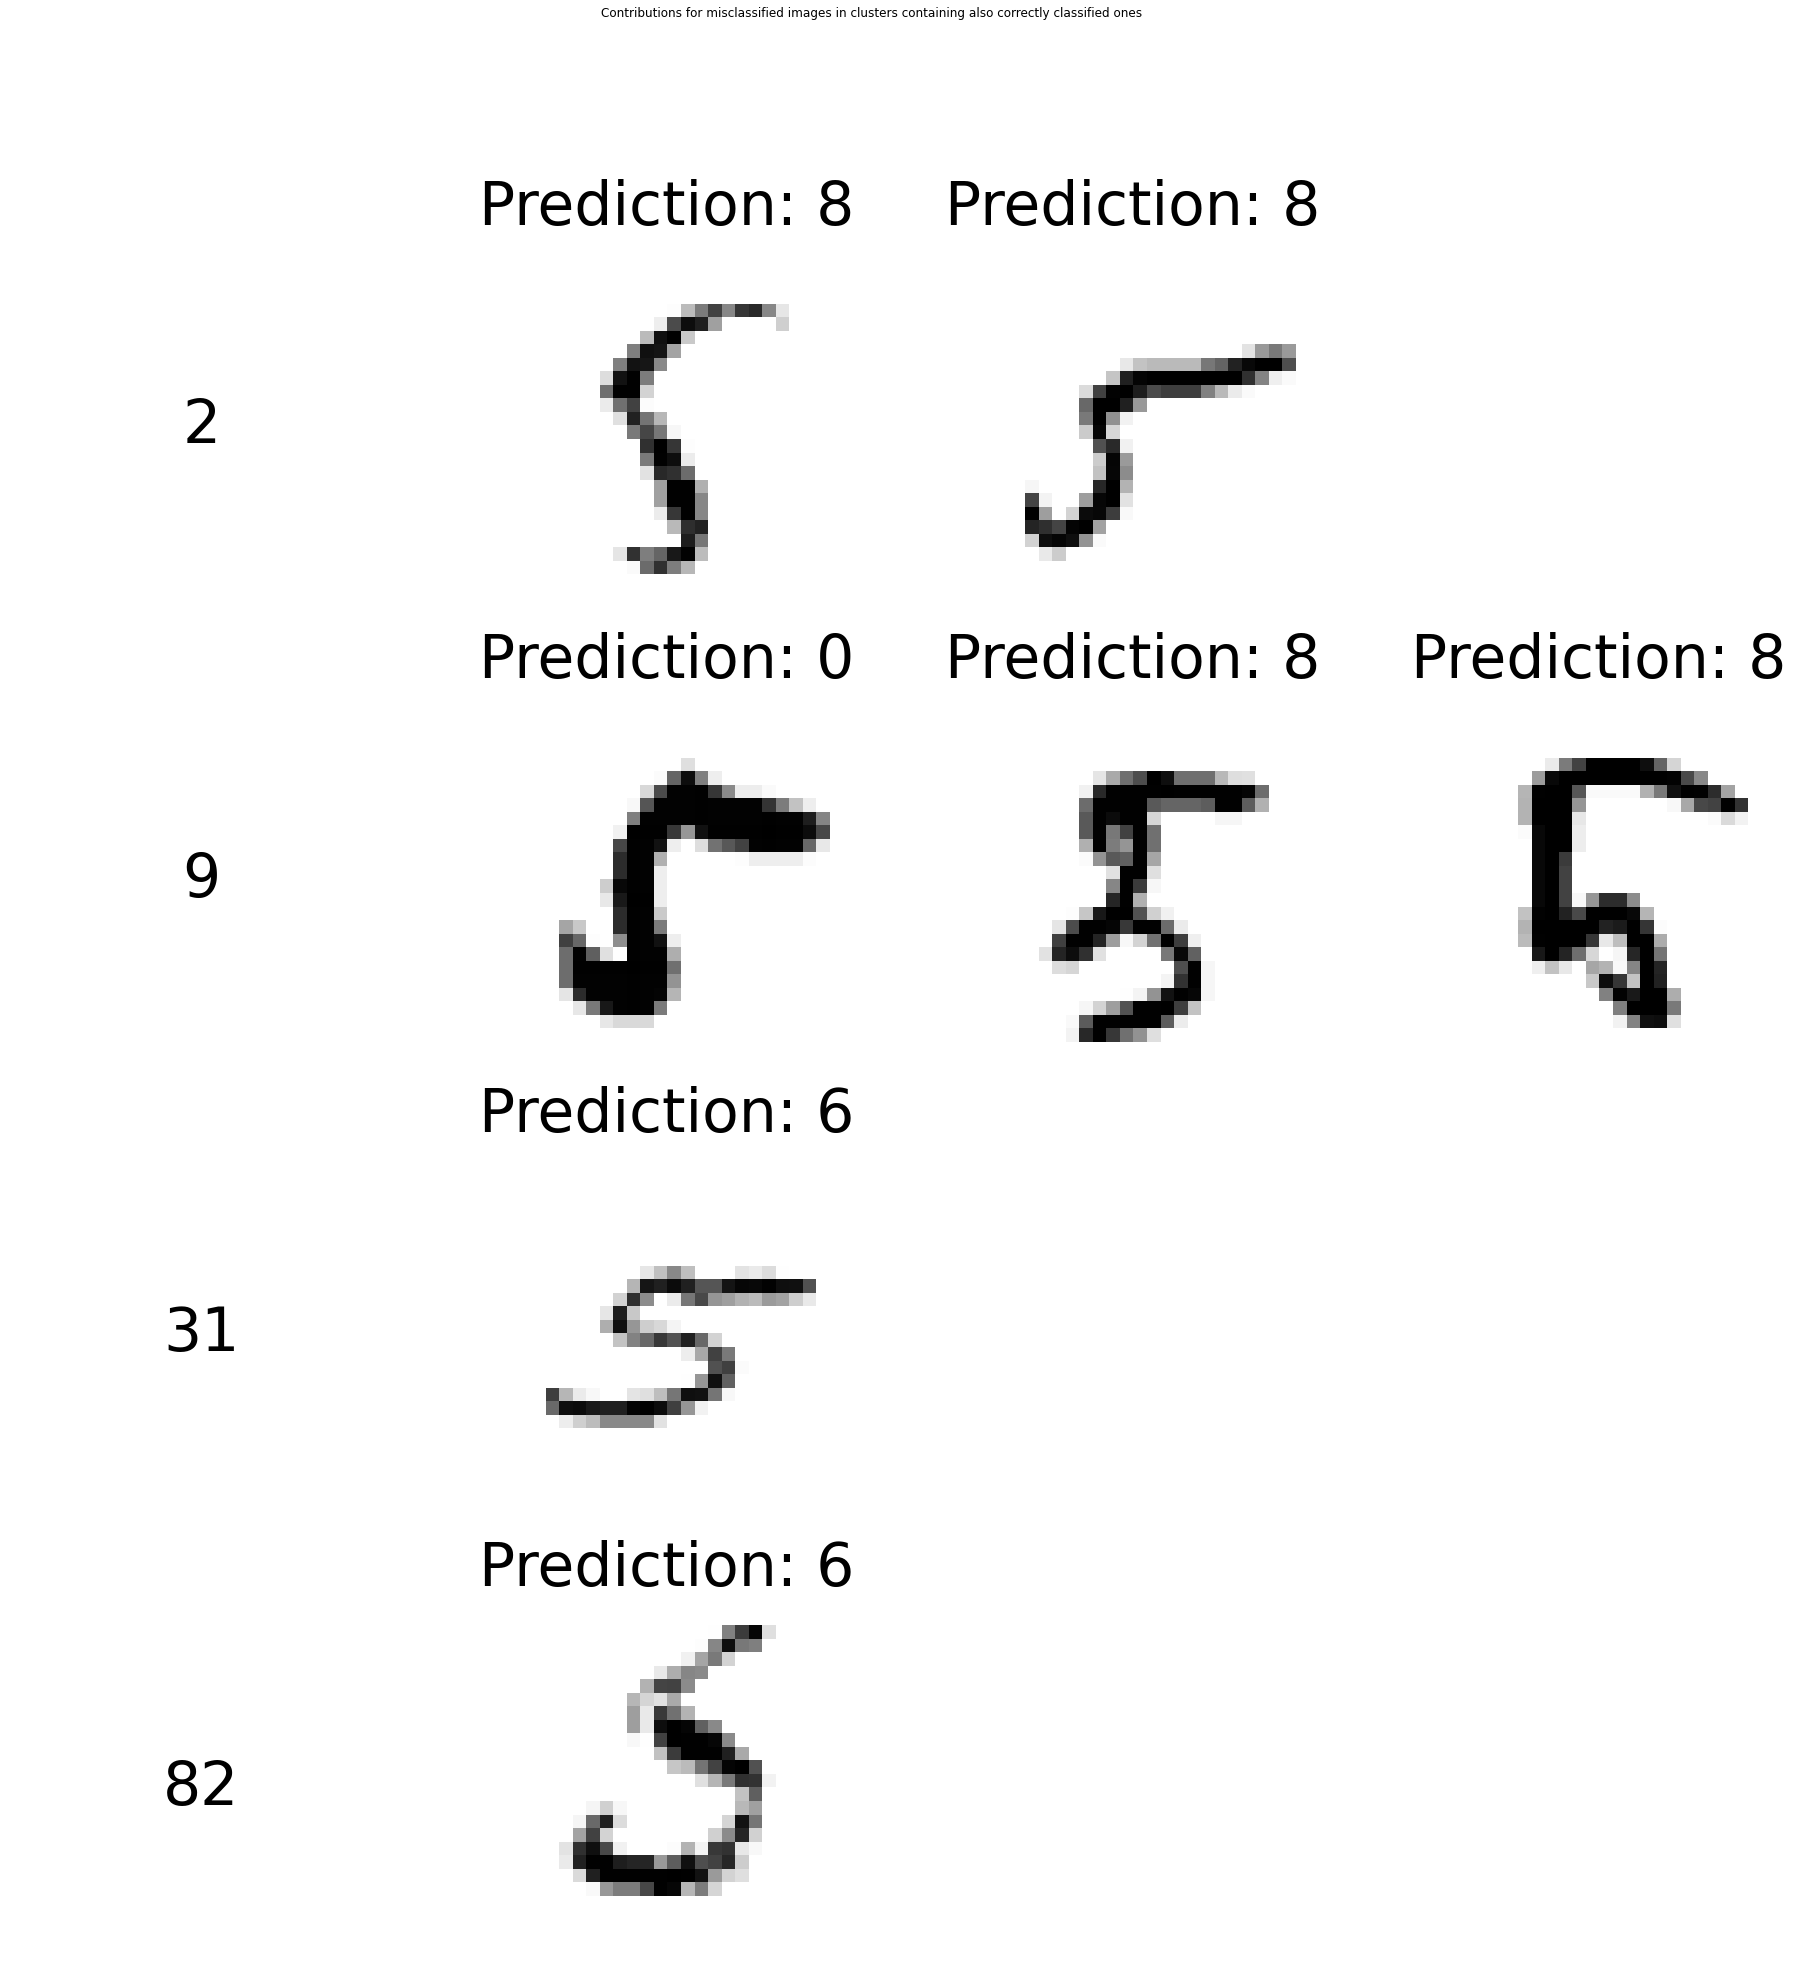

In [63]:
from utils.cluster.visualize import visualize_clusters_images

# sample some clusters labels containing misclassified items
sample_labels = np.random.choice(np.unique(clusters[mask_contains_miss_label]), 4, replace=False)

sample_mask = np.isin(clusters, sample_labels)
# show some correctly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for correctly classified images in clusters containing also misclassified ones')
save_figure(fig, f'../out/feature_maps/clusters_correct_contributions')
# show some incorrectly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for misclassified images in clusters containing also correctly classified ones')
save_figure(fig, f'../out/feature_maps/clusters_misclassified_contributions')

In [64]:
len(set(clusters))

88